# Adaptive PDE discretizations on Cartesian grids
## Volume : Algorithmic tools
## Part : Domain representation
## Chapter : Subsets of $R^d$

This notebook shows how to describe a simple subset of $R^d$, and to compute finite differences taking into account a given Dirichlet data on the boundary. It is a prerequisite to the implementation of monotone schemes on non-rectangular domains.

*Note:* The library presented in this notebook features some elementary primitives of algorithmic geometry. However, their expressivity is rather limited, and exact predicates are not implemented. Therefore, please consider using a dedicated computational geometry package if you intend to go much beyond the basic examples presented in this series of notebooks.

[**Summary**](Summary.ipynb) of volume Algorithmic tools, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Domain description](#1.-Domain-description)
    * [1.1 Basic shapes, boolean operations, affine transformation.](#1.1-Basic-shapes,-boolean-operations,-affine-transformation.)
    * [1.2 Level set function](#1.2-Level-set-function)
    * [1.3 Distance to the boundary in a given direction.](#1.3-Distance-to-the-boundary-in-a-given-direction.)
  * [2. Boundary-adapted finite differences](#2.-Boundary-adapted-finite-differences)
    * [2.1 Interior points](#2.1-Interior-points)
    * [2.2 Upwind finite differences](#2.2-Upwind-finite-differences)
    * [2.3 Centered finite differences](#2.3-Centered-finite-differences)
    * [2.4 Second order finite differences](#2.4-Second-order-finite-differences)
  * [3. Mock boundary conditions](#3.-Mock-boundary-conditions)



**Acknowledgement.** Some of the experiments presented in these notebooks are part of 
ongoing research with Ludovic Métivier and Da Chen.

Copyright Jean-Marie Mirebeau, Centre Borelli, ENS Paris-Saclay, CNRS, University Paris-Saclay

## 0. Import the required libraries

In [1]:
import sys; sys.path.insert(0,"..") # Allow import of agd from parent directory (useless if conda package installed)
#from Miscellaneous import TocTools; print(TocTools.displayTOC('SubsetRd','Algo'))

In [2]:
from agd import Domain 
from agd import AutomaticDifferentiation as ad

In [3]:
import scipy.linalg
import numpy as np
from matplotlib import pyplot as plt

In [4]:
def reload_packages():
    import importlib
    Domain = importlib.reload(sys.modules['agd.Domain'])
    ad = importlib.reload(sys.modules['agd.AutomaticDifferentiation'])
    ad.reload_submodules()

## 1. Domain description

The provided library allows to define a family of basic shapes, combine them with boolean operations, and affine transformations. Once the desired shape is constructed, two main functions are available: a level set map, and the distance to the boundary along a given half line.

### 1.1 Basic shapes, boolean operations, affine transformation.

Define a ball and a box domain, here in dimension two, but these primitives are dimension independent.
* *Ball* $\{x\in R^d;\, \|x-x_0\| \leq r\}$ with parameters $(x_0,r)$, the center and the radius (defaults to one).
* *Box* $[a_1,b_1] \times [a_n,b_n]$, a product of intervals.

In [5]:
ball = Domain.Ball([0,0]) # Two dimensional ball centered at the origin with radius one.
box = Domain.Box([[0,1],[0,1]]) # Square domain [0,1]x[0,1]

The standard boolean operations allow to combine elementary shapes: intersection, union, and relative complement.

In [6]:
cap = Domain.Intersection(ball,box)
cup = Domain.Union(ball,box)
compl = Domain.Complement(ball,box)

Bands and Convex polygons are some potentially useful additional shapes:
* *Band* $\{x\in R^d; b_0 \leq <x,v> \leq b_1$, depending on $(v,b)$, where $v$ is called the direction and $b=(b_0,b_1)$ the bounds. 
* *Convex polygon* $\mathrm{Hull}(x_1,\cdots,x_n)$. This primitive is two dimensional only.

In [7]:
band = Domain.Band([1.,2.],[-2.,1.]) # Direction, bounds
triangle = Domain.ConvexPolygon(np.stack([[1.,0.],[0.,1.],[-1.,-1.]],axis=1))

An affine transformation can be applied to the domain, with parameters:
* *A* (mult) the matrix of the linear part. (defaults to identity)
* $x_0$ (center) the center of the previous linear transformation. (defaults to the origin)
* $v$ (shift) a translation to be applied. (defaults to zero)

The direct mapping takes the form
$$
    x \mapsto A (x-x_0)+x_0 + v
$$

In [8]:
def rot(t): c,s = np.cos(t),np.sin(t); return np.array(((c,-s),(s,c)))    
aff = Domain.AffineTransform(cup,0.7*rot(np.pi/3.),shift=[-0.2,-0.2])

In [9]:
doms = (ball,box,cap,compl,cup,band,triangle,aff)
domNames = ("ball","box","cap","compl","cup","band","triangle","affine")

Let us display the domains.

In [10]:
aX=np.linspace(-1.2,1.2)
X = np.array(np.meshgrid(aX,aX,indexing='ij'))
h=aX[1]-aX[0]

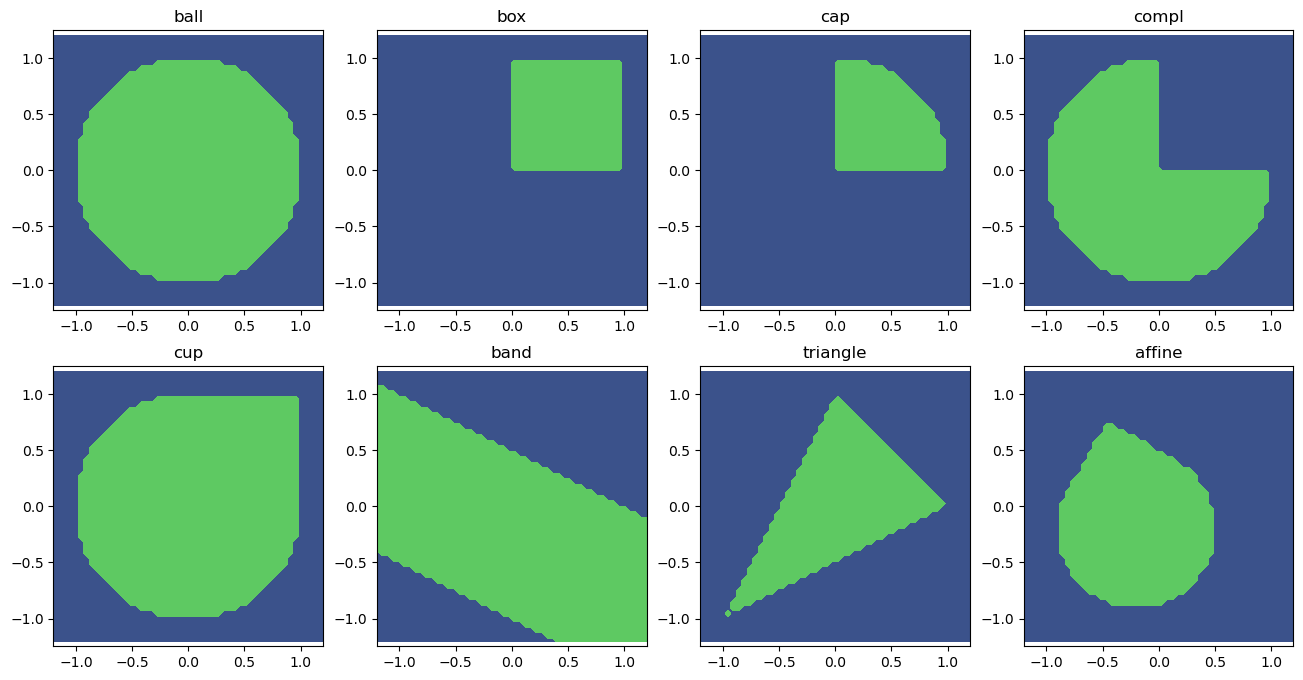

In [11]:
plt.figure(figsize=(16,8))
for i,(dom,name) in enumerate(zip(doms,domNames)):
    plt.subplot(2,4,1+i)
    plt.contourf(*X,dom.contains(X))
    plt.title(name)
    plt.axis('equal')

It is possible to select the points around which the domain contains a ball of a given radius $h$, possibly negative. This predicate is only approximate.

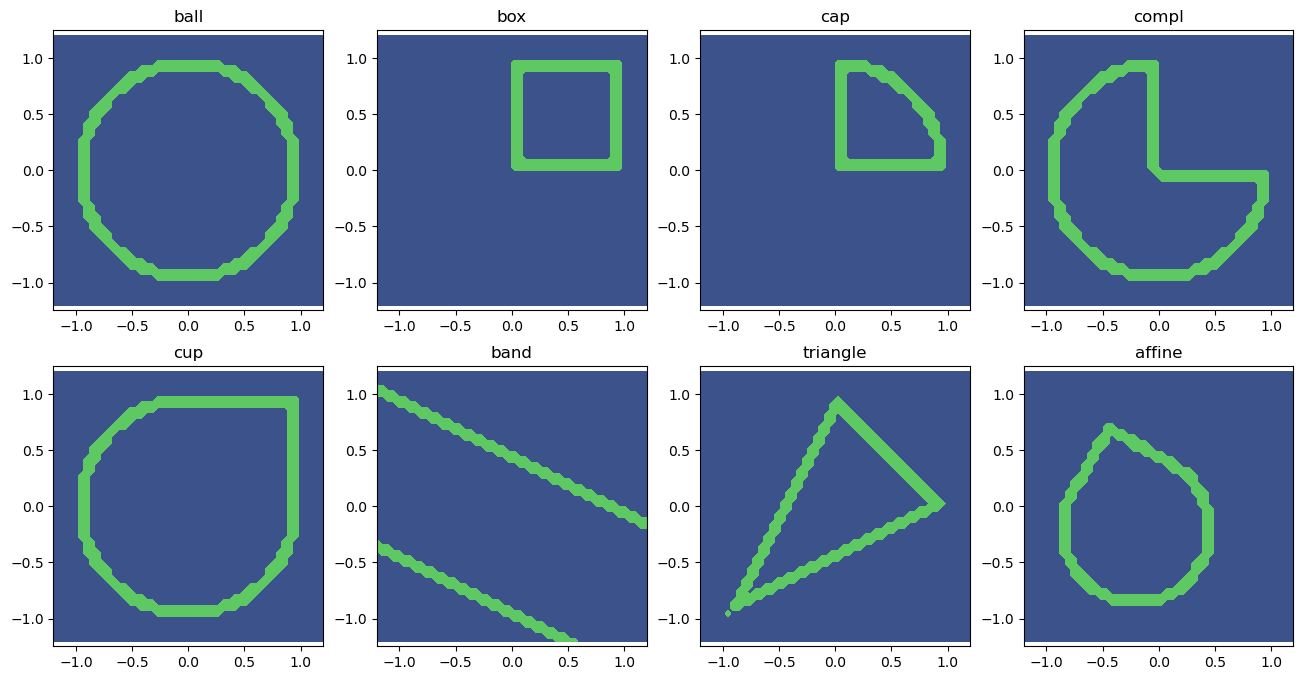

In [12]:
plt.figure(figsize=(16,8))
for i,(dom,name) in enumerate(zip(doms,domNames)):
    plt.subplot(2,4,1+i)
    
    interior = dom.contains(X)
    erosion = dom.contains_ball(X,2*h)
    boundary_layer = np.logical_and(interior,np.logical_not(erosion))
    
    plt.contourf(*X,boundary_layer)
    plt.title(name)
    plt.axis('equal')

### 1.2 Level set function

Each domain comes equipped with a level set function, that is negative inside the domain, and positive outside. It is also guaranteed to be $1$-Lipschitz. 

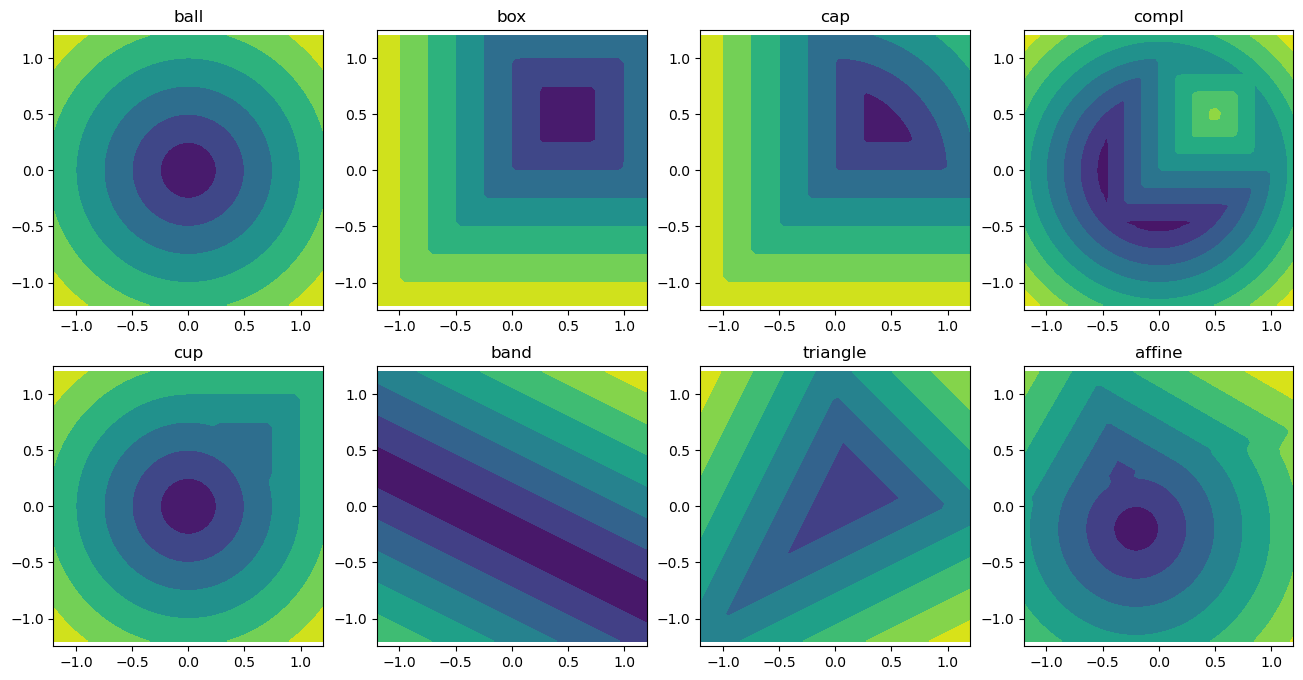

In [13]:
plt.figure(figsize=(16,8))
for i,(dom,name) in enumerate(zip(doms,domNames)):
    plt.subplot(2,4,1+i)
    plt.contourf(*X,dom.level(X))
    plt.title(name)
    plt.axis('equal')

This level set function is in general different from the signed Euclidean distance to the boundary.  
If you do need the Euclidean distance function, you may consider solving an eikonal equation, or using an adequate computational geometry package.

### 1.3 Distance to the boundary in a given direction.

For the design of finite difference schemes, it is important to know the distance from a given point to the domain boundary in a given direction. This is referred to as the "free way" from $x$ in the direction $v$.

In [14]:
#Domain = importlib.reload(Domain)
#ball = Domain.Ball(np.array([0,0]))
#box = Domain.Box([[0,1],[0,1]])
#cap = Domain.Intersection( (ball,box) )
#abox = Domain.AbsoluteComplement(box)
#aball = Domain.AbsoluteComplement(ball)
#compl = Domain.Complement(ball,box)
#cup = Domain.Union((ball,box))
#acup = Domain.Intersection((aball,abox))
#band = Domain.Band([1.,2.],[-2.,1.]) # Direction, bounds

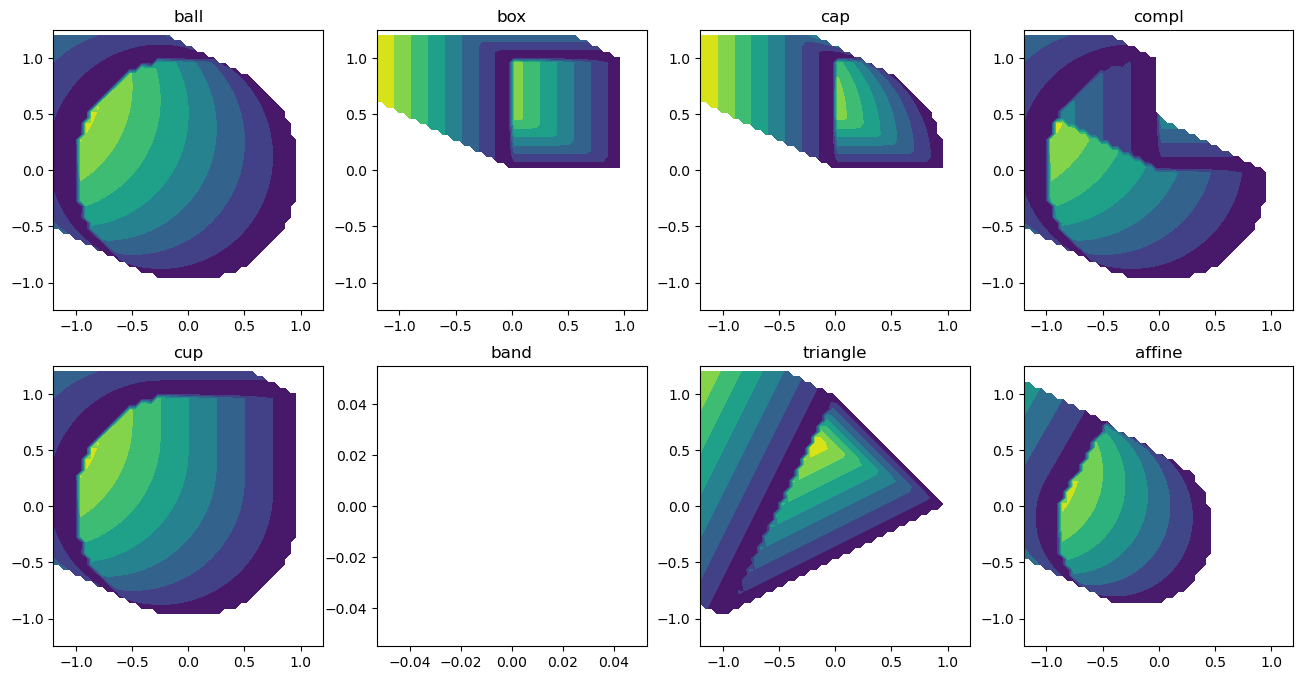

In [15]:
v=np.array([1,-0.5])
plt.figure(figsize=(16,8))
for i,(dom,name) in enumerate(zip(doms,domNames)):
    plt.subplot(2,4,i+1)
    plt.title(name)
    plt.axis('equal')
    fw = dom.freeway(X,v)
    if np.all(fw==np.inf): continue #Warning triggered otherwise 
    plt.contourf(*X,fw)

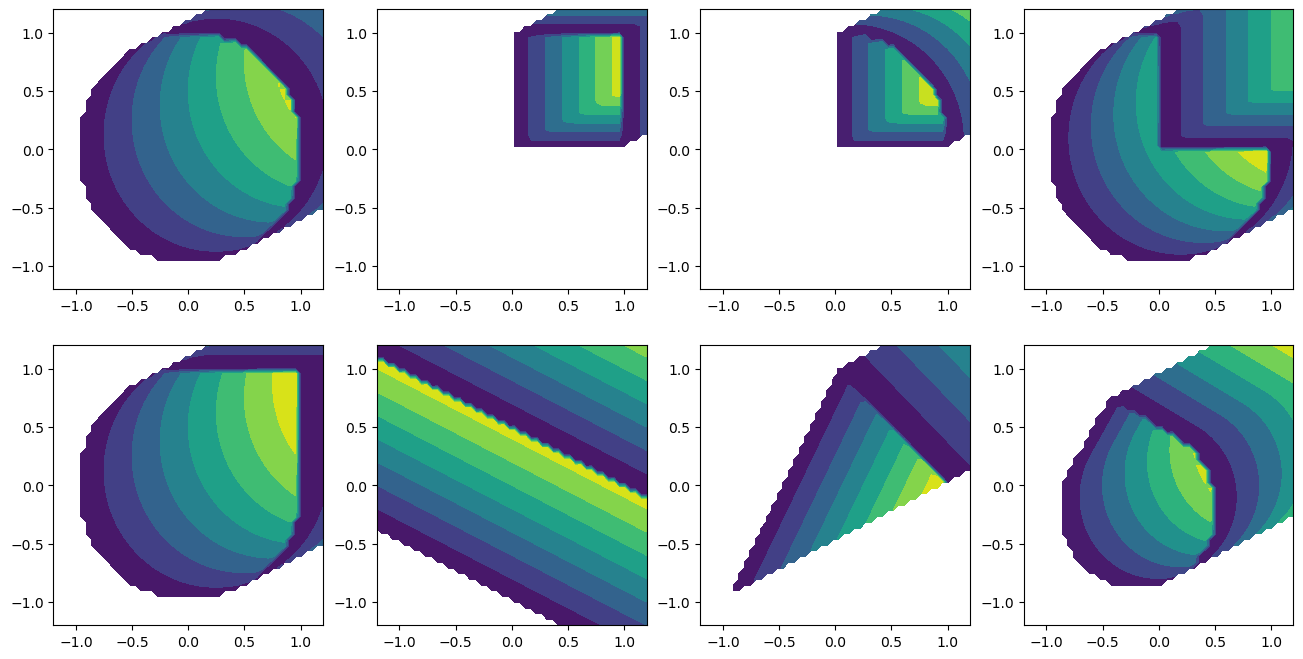

In [16]:
v=np.array([-1,-0.5])
plt.figure(figsize=(16,8))
for i,(dom,name) in enumerate(zip(doms,domNames)):
    plt.subplot(2,4,i+1)
    plt.contourf(*X,dom.freeway(X,v))

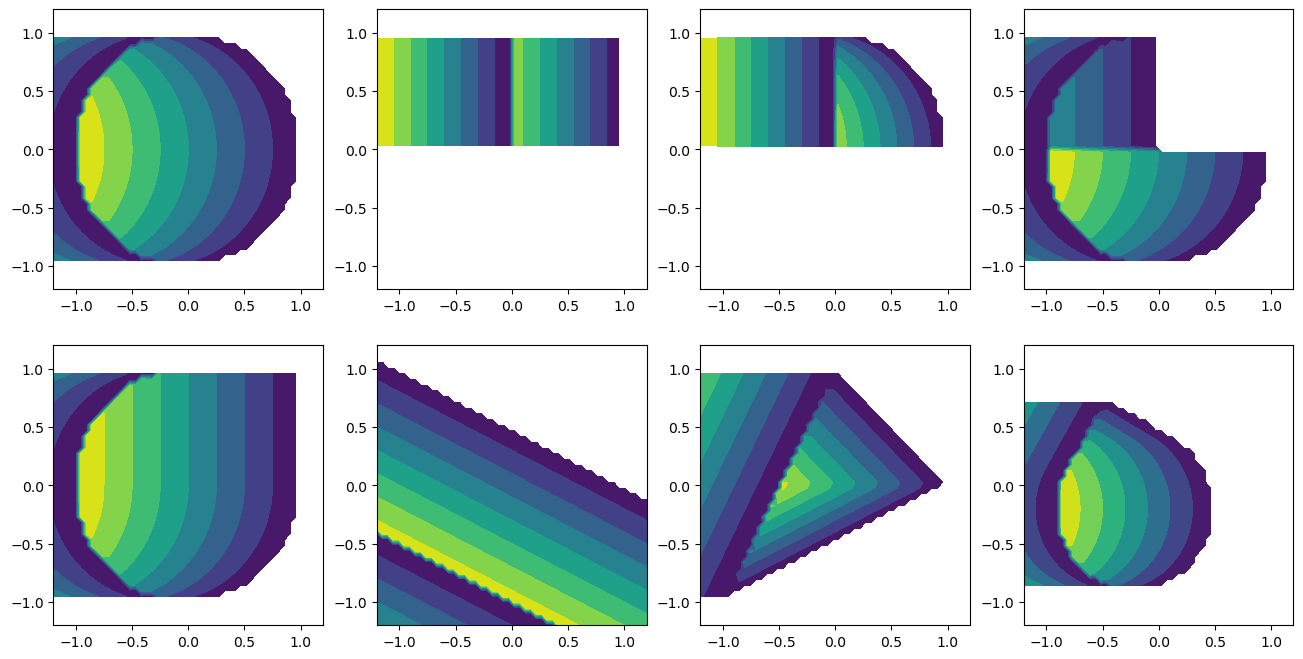

In [17]:
v=np.array([1,0.])
plt.figure(figsize=(16,8))
for i,(dom,name) in enumerate(zip(doms,domNames)):
    plt.subplot(2,4,i+1)
    plt.contourf(*X,dom.freeway(X,v))

## 2. Boundary-adapted finite differences

Only Dirichlet boundary conditions are implemented at present. When a grid point falls outside the domain, the provided boundary data is used instead, as described below.

Denote by $\Omega$ the domain, and $\Omega_h$ its intersection with the cartesian grid $h Z^d$. Let $x\in \Omega_h$ be a point of the domain, and let $e \in Z^d\setminus \{0\}$ be an offset.

* *Upwind finite difference*.  Denote by $h_+>0$ the smallest real such that $x+h_+ e  \in \Omega_h \cup \partial \Omega$. The first order upwind finite difference is defined as
$$
    \delta^e_h u(x) := \frac{u(x+h_+e)-u(x)} {h_+}
$$
* *Centered finite difference*. The standard expression $(u(x+h e)-u(x-he))/(2h)$ is used, unless $x+ h e\notin \Omega_h$ or $x-he \notin \Omega_h$. In that case, we fall back to the upwind finite difference.
* *Second order finite difference*. Let $h_\pm>0$ denote the smallest real such that $x\pm h_\pm e \in \Omega_h \cup \partial \Omega$. The second order finite difference is defined as 
$$
    \Delta^e_h u(x) := \frac 2 {h_++h_-} \Big(\frac{u(x+h_+ e)-u(x)}{h_+} + \frac{u(x-h_- e)-u(x)}{h_-} \Big)
$$

Define the dirichlet data, based on a domain,a function defined on (at least) the boundary, and the cartesian grid.

In [18]:
def bc_value(x): return x[0]+2*x[1]
bc_domain = cup
bc = Domain.Dirichlet(bc_domain,bc_value,X)

### 2.1 Interior points

The gridscale of the domain is automatically extracted. Note that we only support gridscales which are axis independent and position independent.

In [19]:
bc.gridscale

0.048979591836734615

A boolean mask of interior points is constructed.

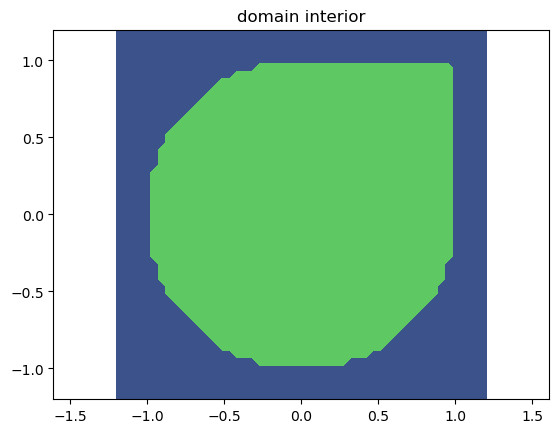

In [20]:
plt.title('domain interior'); plt.axis('equal')
plt.contourf(*X,bc.interior);

Actually, this is a very slightly eroded version of the domain, for numerical stability. 
<!---which does not strictly contain all points of $X$ within it. The purpose of this erosion is to bound below the denominators $h_+$ and $h_-$ in the finite differences at the boundary, for better stability.

If necessary, the set of interior points can be explicitly specified at initialization, or even modified afterwards.
--->

### 2.2 Upwind finite differences

We choose a linear function, in order to confirm that the upwind scheme is exact in this case.

In [21]:
u = bc.value(X)

In [22]:
du = bc.DiffUpwind(u,(1,0))

In [23]:
du[bc.interior].max(),du[bc.interior].min()

(1.0000000000000142, 0.9999999999999833)

Largest and smallest h in finite differences: 0.048979591836734615 0.00047605827449359595


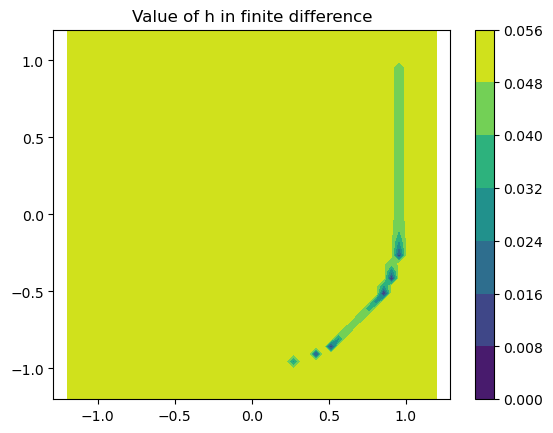

In [24]:
du,h = bc.DiffUpwind(u,(1,0),reth=True)
print("Largest and smallest h in finite differences:",np.max(h),np.min(h))
plt.title("Value of h in finite difference"); plt.axis('equal')
plt.contourf(*X,h); plt.colorbar();

Differentiating along the horizontal and vertical directions simultaneously.

In [25]:
du = bc.DiffUpwind(u,np.eye(2).astype(int))

In [26]:
du[0,bc.interior].max(),du[0,bc.interior].min()

(1.0000000000000142, 0.9999999999999833)

In [27]:
du[1,bc.interior].max(),du[1,bc.interior].min()

(2.000000000000028, 1.9999999999999858)

### 2.3 Centered finite differences

Again, we choose a linear function, in order to confirm that the upwind scheme is exact in this case.

In [28]:
du = bc.DiffCentered(u,(1,0))

In [29]:
du[bc.interior].max(),du[bc.interior].min()

(1.000000000000007, 0.9999999999999833)

In [30]:
du = bc.DiffCentered(u,np.eye(2).astype(int))

In [31]:
du[0,bc.interior].max(),du[0,bc.interior].min()

(1.000000000000007, 0.9999999999999833)

In [32]:
du[1,bc.interior].max(),du[1,bc.interior].min()

(2.000000000000028, 1.99999999999999)

### 2.4 Second order finite differences

The second order differences of a linear function identically vanish.

In [33]:
d2u = bc.Diff2(u,(1,0))

In [34]:
d2u[bc.interior].max(),d2u[bc.interior].min()

(1.1536608264867289e-11, -5.983034965740204e-13)

In [35]:
d2u = bc.Diff2(u,np.eye(2).astype(int))

In [36]:
d2u[0,bc.interior].max(),d2u[0,bc.interior].min()

(1.1536608264867289e-11, -5.983034965740204e-13)

In [37]:
d2u[1,bc.interior].max(),d2u[1,bc.interior].min()

(1.9440713794339614e-11, -5.802765675374161e-13)

We need to use quadratic polynomials to illustrate consistency in a non-trivial manner.

In [38]:
def bc2_value(x): return x[0]**2+x[0]*x[1]
bc2 = Domain.Dirichlet(bc_domain,bc2_value,X)

In [39]:
u2 = bc2.value(X)

In [40]:
d2u = bc2.Diff2(u2,(1,0))
d2u[bc.interior].max(),d2u[bc.interior].min()

(2.0000000000041758, 1.9999999999877116)

In [41]:
d2u = bc2.Diff2(u2,np.eye(2).astype(int))

In [42]:
d2u[0,bc.interior].max(),d2u[0,bc.interior].min()

(2.0000000000041758, 1.9999999999877116)

In [43]:
d2u[1,bc.interior].max(),d2u[1,bc.interior].min()

(4.265283626933634e-12, -8.961585388799509e-12)

## 3. Mock boundary conditions

There is an alternative way of handling boundary conditions, which is simpler but also much more crude and inaccurate. In that approach, the boundary data is provided in a *neighborhood* of the boundary, and the standard finite difference schemes is used.

Be warned that this alternative is both:
* Excessively unprecise in applications, because an $O(h)$ error is introduced when extending the boundary conditions.
* Excessively precise in synthetic test cases, because the boundary solution is typically the exact analytical solution, which in this way is provided in a substantial narrow band along the boundary.

In view of these caveats, we refer to it as mock boundary conditions.

In [44]:
grid_values = bc_value(X) # Boundary conditions are evaluated in the whole domain
grid_values[ np.logical_not(bc_domain.contains(X)) ] = np.nan # Define the domain

bc_mock = Domain.MockDirichlet(grid_values,h)

In that approach, the domain is actually not taken into account when computing the finite differences.

However, the provided placeholder values are those of the boundary condition, instead of an arbitrary default. This makes sense in view of the numerical schemes implementation, see e.g. [link](../Notebooks_NonDiv/LinearMonotoneSchemes2D.ipynb)

In [45]:
bc_mock.grid_values is grid_values # Returns the extended boundary conditions 

True

In [46]:
bc.grid_values # Arbitrary placeholder

0.0